In [1]:
%reload_ext autoreload
%autoreload 2

In [87]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
from swallows.training import *
from swallows.models import *
import time
from IPython.display import FileLink, FileLinks
from swallows.plots import *

In [3]:
path=Path('data')

In [4]:
model_name = 'ensemble-v3'

In [5]:
nlp_model_name = 'details-60k'
nlp_encoder_name = f'{nlp_model_name}-tuned-enc'
tab_model_name = f'tab-v4-tuning-3-stage-4-hyper-{30}-{0.001}-{0.2}-fitted'

In [6]:
bs = 256

# Data Packaging

In [7]:
df_train = pd.read_parquet(path/'processed/training_stage_4.parquet', engine='fastparquet')

In [8]:
cont_names = [] # ['create_to_assigned_lag_log']

exclude_from_cats = [
    'ID', 
    'assigned_date',
    'create_date',
    'details',
    'short_description',
    'amazon_domains',
    'root_cause',
    'create_to_assigned_lag'
    'create_to_assigned_lag_log',
    'assigned_date_Elapsed'
    'create_date_Elapsed',
] + cont_names

cat_names = [c for c in df_train.columns if c not in exclude_from_cats]
dep_var = 'root_cause'
procs = [FillMissing, Categorify, Normalize]

In [9]:
large_cats = remove_targets_with_low_frequency(df_train, 'root_cause', min_cat_size=500)

Total cats: 960 with 1156151 items
cats w/ >500 items: 81 with 97.40% coverage


In [10]:
train_data = df_train[df_train['root_cause'].isin(large_cats.reset_index()['root_cause'])]

In [11]:
# splits_idxs = [s for s in gen_splits(10, train_data, 'root_cause')]
# pickle.dump(splits_idxs, open(path/f'{model_name}_cv_splits-10.pkl', "wb"))
splits_idxs = pickle.load(open(path/f'{model_name}_cv_splits-10.pkl', "rb"))
split = splits_idxs[7]

In [12]:
data_lm = load_data(path, f'data-lm-{nlp_model_name}.pkl', bs=bs)
vocab = data_lm.vocab

In [13]:
list_tab = TabularList.from_df(train_data[cat_names + cont_names + [dep_var]], cat_names=cat_names, cont_names=cont_names, procs=procs, path=path)
list_text = TextList.from_df(train_data[['details']], cols='details', path=path, vocab=vocab)

#### Create mixed databunch

In [14]:
# data_text = (TextList.from_df(train_data[['details','root_cause']], cols='details', path=path, vocab=vocab)
#                 .split_by_idxs(split[0], split[1])
#                 .label_from_df(cols=dep_var)
#                 .databunch(bs=bs))
# data_text.save(f'{model_name}_data_text')

data_text = load_data(path, f'{model_name}_data_text', bs=bs)

In [15]:
# data_tab = (TabularList.from_df(train_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
#                            .split_by_idxs(split[0], split[1])
#                            .label_from_df(cols=dep_var)
#                            .databunch(bs=bs))
# data_tab.save(f'{model_name}_data_tab')

data_tab = load_data(path, f'{model_name}_data_tab', bs=bs)

In [16]:
data = mixed_data_bunch(path, data_text, data_tab, bs)

# Training

#### Load models

In [30]:
def build_learner(data):
    nlp_model, nlp_layer_groups = load_nlp_backbone(data_text, nlp_encoder_name)
    tab_model, tab_layer_groups = load_tabular_backbone(data_tab, tab_model_name)
    
    lin_layers = [nlp_model[1].layers[2].out_features + tab_model.layers[4].out_features, len(data.classes)]
    model = EnsembleModel(tab_model, nlp_model, lin_layers, drops=[0.2])
    
    layer_groups = [nn.Sequential(*(flatten_model(nlp_layer_groups[0]) + flatten_model(tab_layer_groups[0]))),
                nn.Sequential(*flatten_model(nlp_layer_groups[1])),
                nn.Sequential(*flatten_model(nlp_layer_groups[2])),
                nn.Sequential(*flatten_model(nlp_layer_groups[3])),
                nn.Sequential(*flatten_model(nlp_layer_groups[4])),
                nn.Sequential(*flatten_model(model.layers))]
    
    learn = Learner(data, model, metrics=accuracy_v2, layer_groups=layer_groups)
    return learn

#### Training

In [18]:
learn = build_learner(data)
learn.freeze()

epoch,train_loss,valid_loss,accuracy_v2,time
0,1.215049,1.253530,0.598726,10:03


Better model found at epoch 0 with accuracy_v2 value: 0.5987263321876526.


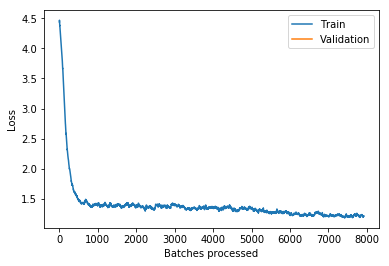

In [19]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-1a')
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

In [20]:
learn.freeze_to(-2)

In [21]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-2a')
learn.fit_one_cycle(1, slice(1e-4/(2.6**5),1e-4), moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy_v2,time


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
learn.freeze_to(-3)

In [23]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-3a')
learn.fit_one_cycle(1, slice(1e-3/(2.6**5),1e-3), moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy_v2,time


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
learn.unfreeze()

In [27]:
learn.validate()

[1.2256035, tensor(0.6103)]

epoch,train_loss,valid_loss,accuracy_v2,time
0,1.157710,1.209613,0.613497,26:59
1,1.128874,1.201710,0.616064,27:45
2,1.139308,1.200301,0.616970,28:43


Better model found at epoch 0 with accuracy_v2 value: 0.6134968996047974.
Better model found at epoch 1 with accuracy_v2 value: 0.6160637140274048.
Better model found at epoch 2 with accuracy_v2 value: 0.6169697046279907.


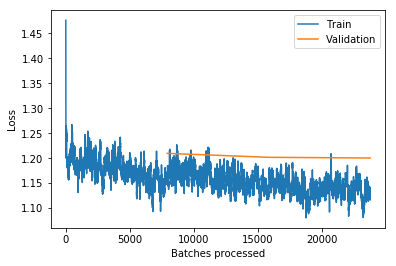

In [28]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-fitted-a')
learn.fit_one_cycle(3, slice(5e-4/(2.6**5),5e-4), moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy_v2,time
0,1.167528,1.206944,0.617858,30:07


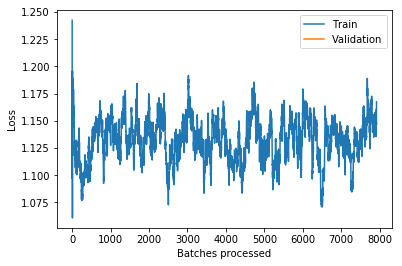

In [43]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-4/(2.6**3),1e-4), moms=(0.8, 0.7)); learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy_v2,time
0,1.169382,1.199413,0.617858,28:00


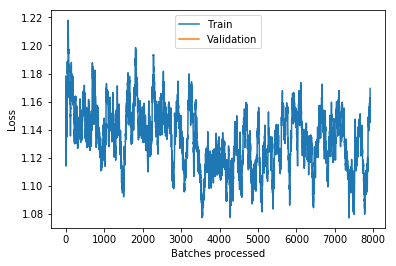

In [45]:
learn.fit_one_cycle(1, slice(1e-5/(2.6**3),1e-5), moms=(0.8, 0.7)); learn.recorder.plot_losses()

In [46]:
learn.save(f'{model_name}-fitted-full') # << this one overfitted pub scored: 0.601460360771

Public leaderboard score: 0.601569342918

# Predict

In [31]:
df_test = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet', engine='fastparquet')
df_test_ids = pd.read_csv(path/'public_test_features_IDs.csv', low_memory=False)

In [32]:
data_text.add_test(TextList.from_df(df_test[['details']], path, vocab=data_lm.vocab))
data_tab.add_test(TabularList.from_df(df_test[cat_names + cont_names], path=path, cat_names=cat_names, cont_names=cont_names))

In [33]:
data_test = mixed_data_bunch(path, data_text, data_tab, bs)

In [53]:
learn_test = build_learner(data_test)
learn_test.load(f'{model_name}-fitted-a')

Learner(data=DataBunch;

Train: <swallows.models.EnsembleDataset object at 0x7f35b26befd0>;

Valid: <swallows.models.EnsembleDataset object at 0x7f35b26bef60>;

Test: <swallows.models.EnsembleDataset object at 0x7f356f869160>, model=EnsembleModel(
  (mod_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(448, 49)
      (1): Embedding(8, 5)
      (2): Embedding(92, 20)
      (3): Embedding(6, 4)
      (4): Embedding(1565, 98)
      (5): Embedding(5, 4)
      (6): Embedding(3, 3)
      (7): Embedding(1028, 78)
      (8): Embedding(2241, 120)
      (9): Embedding(36, 12)
      (10): Embedding(1071, 80)
      (11): Embedding(34, 12)
      (12): Embedding(1869, 109)
      (13): Embedding(6, 4)
      (14): Embedding(311, 40)
      (15): Embedding(517, 53)
      (16): Embedding(34, 12)
      (17): Embedding(3, 3)
      (18): Embedding(3, 3)
      (19): Embedding(3, 3)
      (20): Embedding(3, 3)
      (21): Embedding(3, 3)
      (22): Embedding(3, 3)
      (23): Embedding(3, 3

In [49]:
preds,y = learn_test.get_preds(ds_type=DatasetType.Test)

In [50]:
pred_classes = [data_test.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [51]:
df_out = pd.DataFrame({'ID': df_test_ids['ID'], 'root_cause': pred_classes})

In [52]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_{t}_{model_name}.csv'
df_out.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_2019_05_03_04_46_ensemble-v3.csv

# Interpretation

In [58]:
learn_test = build_learner(data_test)
learn_test.load(f'{model_name}-fitted-a')

Learner(data=DataBunch;

Train: <swallows.models.EnsembleDataset object at 0x7f35b26befd0>;

Valid: <swallows.models.EnsembleDataset object at 0x7f35b26bef60>;

Test: <swallows.models.EnsembleDataset object at 0x7f356f869160>, model=EnsembleModel(
  (mod_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(448, 49)
      (1): Embedding(8, 5)
      (2): Embedding(92, 20)
      (3): Embedding(6, 4)
      (4): Embedding(1565, 98)
      (5): Embedding(5, 4)
      (6): Embedding(3, 3)
      (7): Embedding(1028, 78)
      (8): Embedding(2241, 120)
      (9): Embedding(36, 12)
      (10): Embedding(1071, 80)
      (11): Embedding(34, 12)
      (12): Embedding(1869, 109)
      (13): Embedding(6, 4)
      (14): Embedding(311, 40)
      (15): Embedding(517, 53)
      (16): Embedding(34, 12)
      (17): Embedding(3, 3)
      (18): Embedding(3, 3)
      (19): Embedding(3, 3)
      (20): Embedding(3, 3)
      (21): Embedding(3, 3)
      (22): Embedding(3, 3)
      (23): Embedding(3, 3

In [59]:
preds,y = learn_test.get_preds(ds_type=DatasetType.Valid)

In [63]:
pred_classes = [data_test.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [68]:
actl_classes = [data_test.classes[cls] for cls in y]

In [70]:
from sklearn.metrics import confusion_matrix

In [76]:
cnf_matrix = confusion_matrix(y, np.argmax(preds.numpy(), axis=1))

Normalized confusion matrix


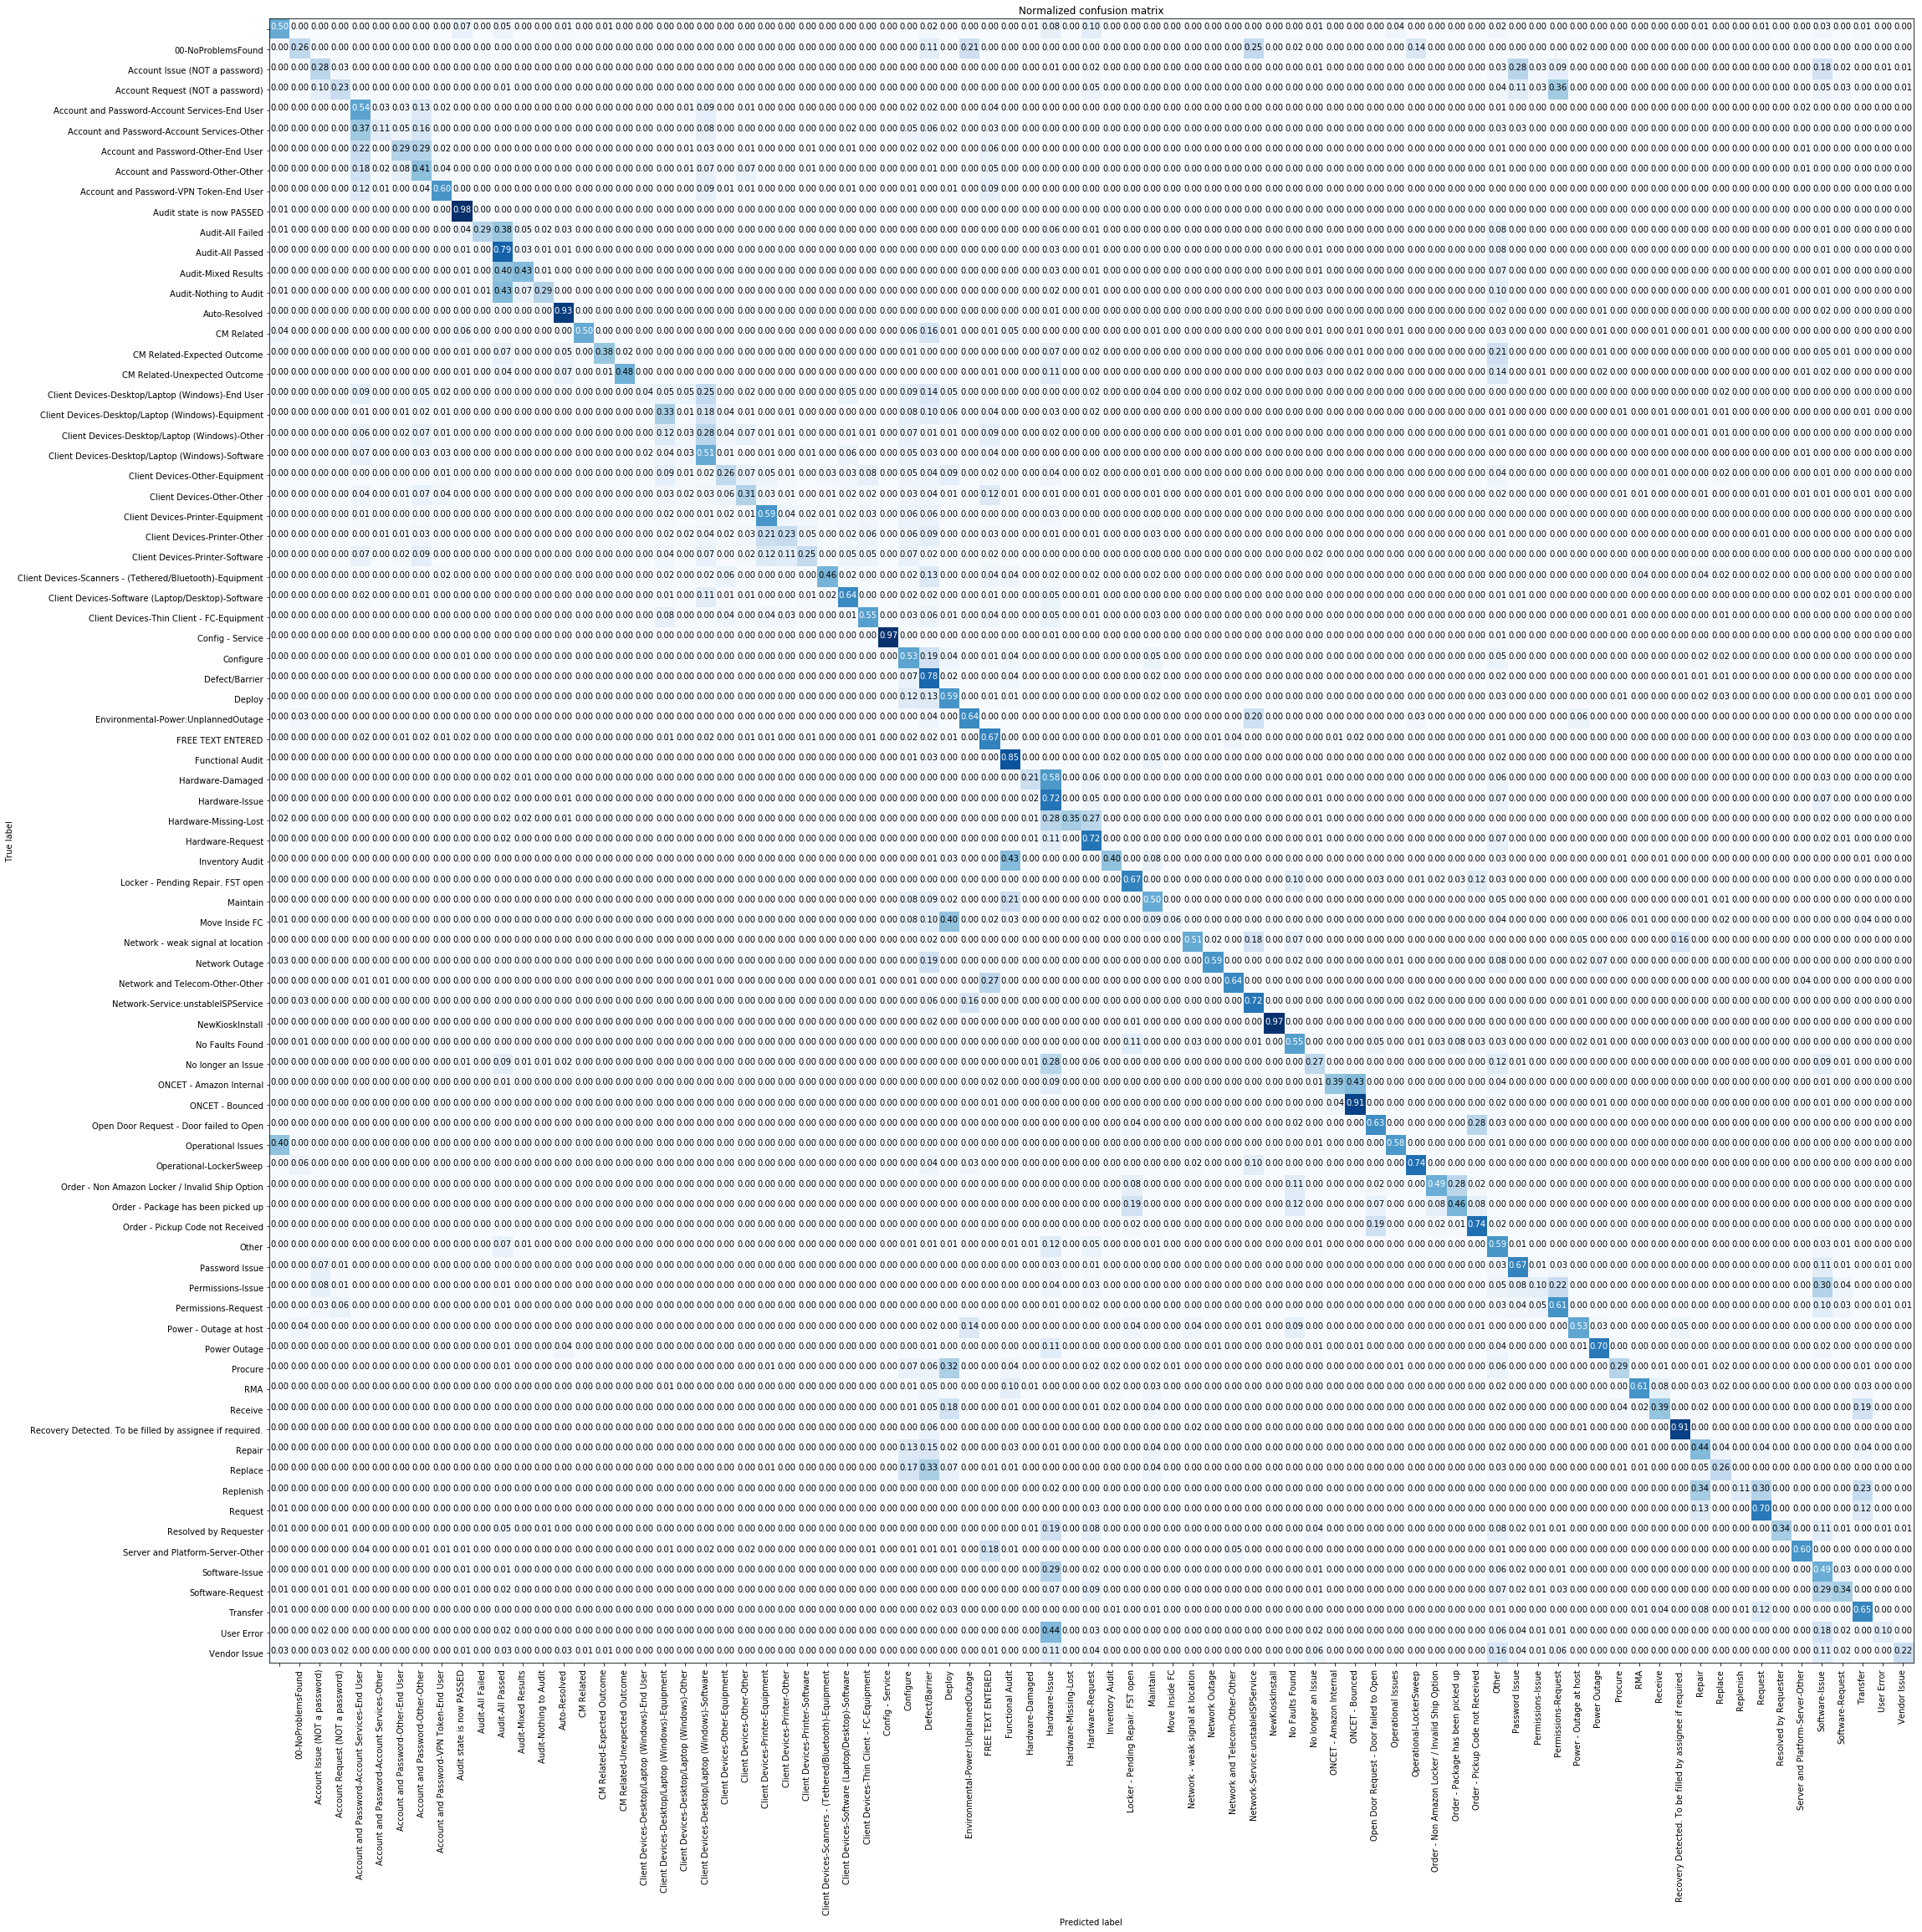

In [85]:
fig = plt.figure()
fig.set_size_inches(32, 32, forward=True)
plot_confusion_matrix(cnf_matrix, classes=data_test.classes, normalize=True, title='Normalized confusion matrix')

Confusion matrix, without normalization


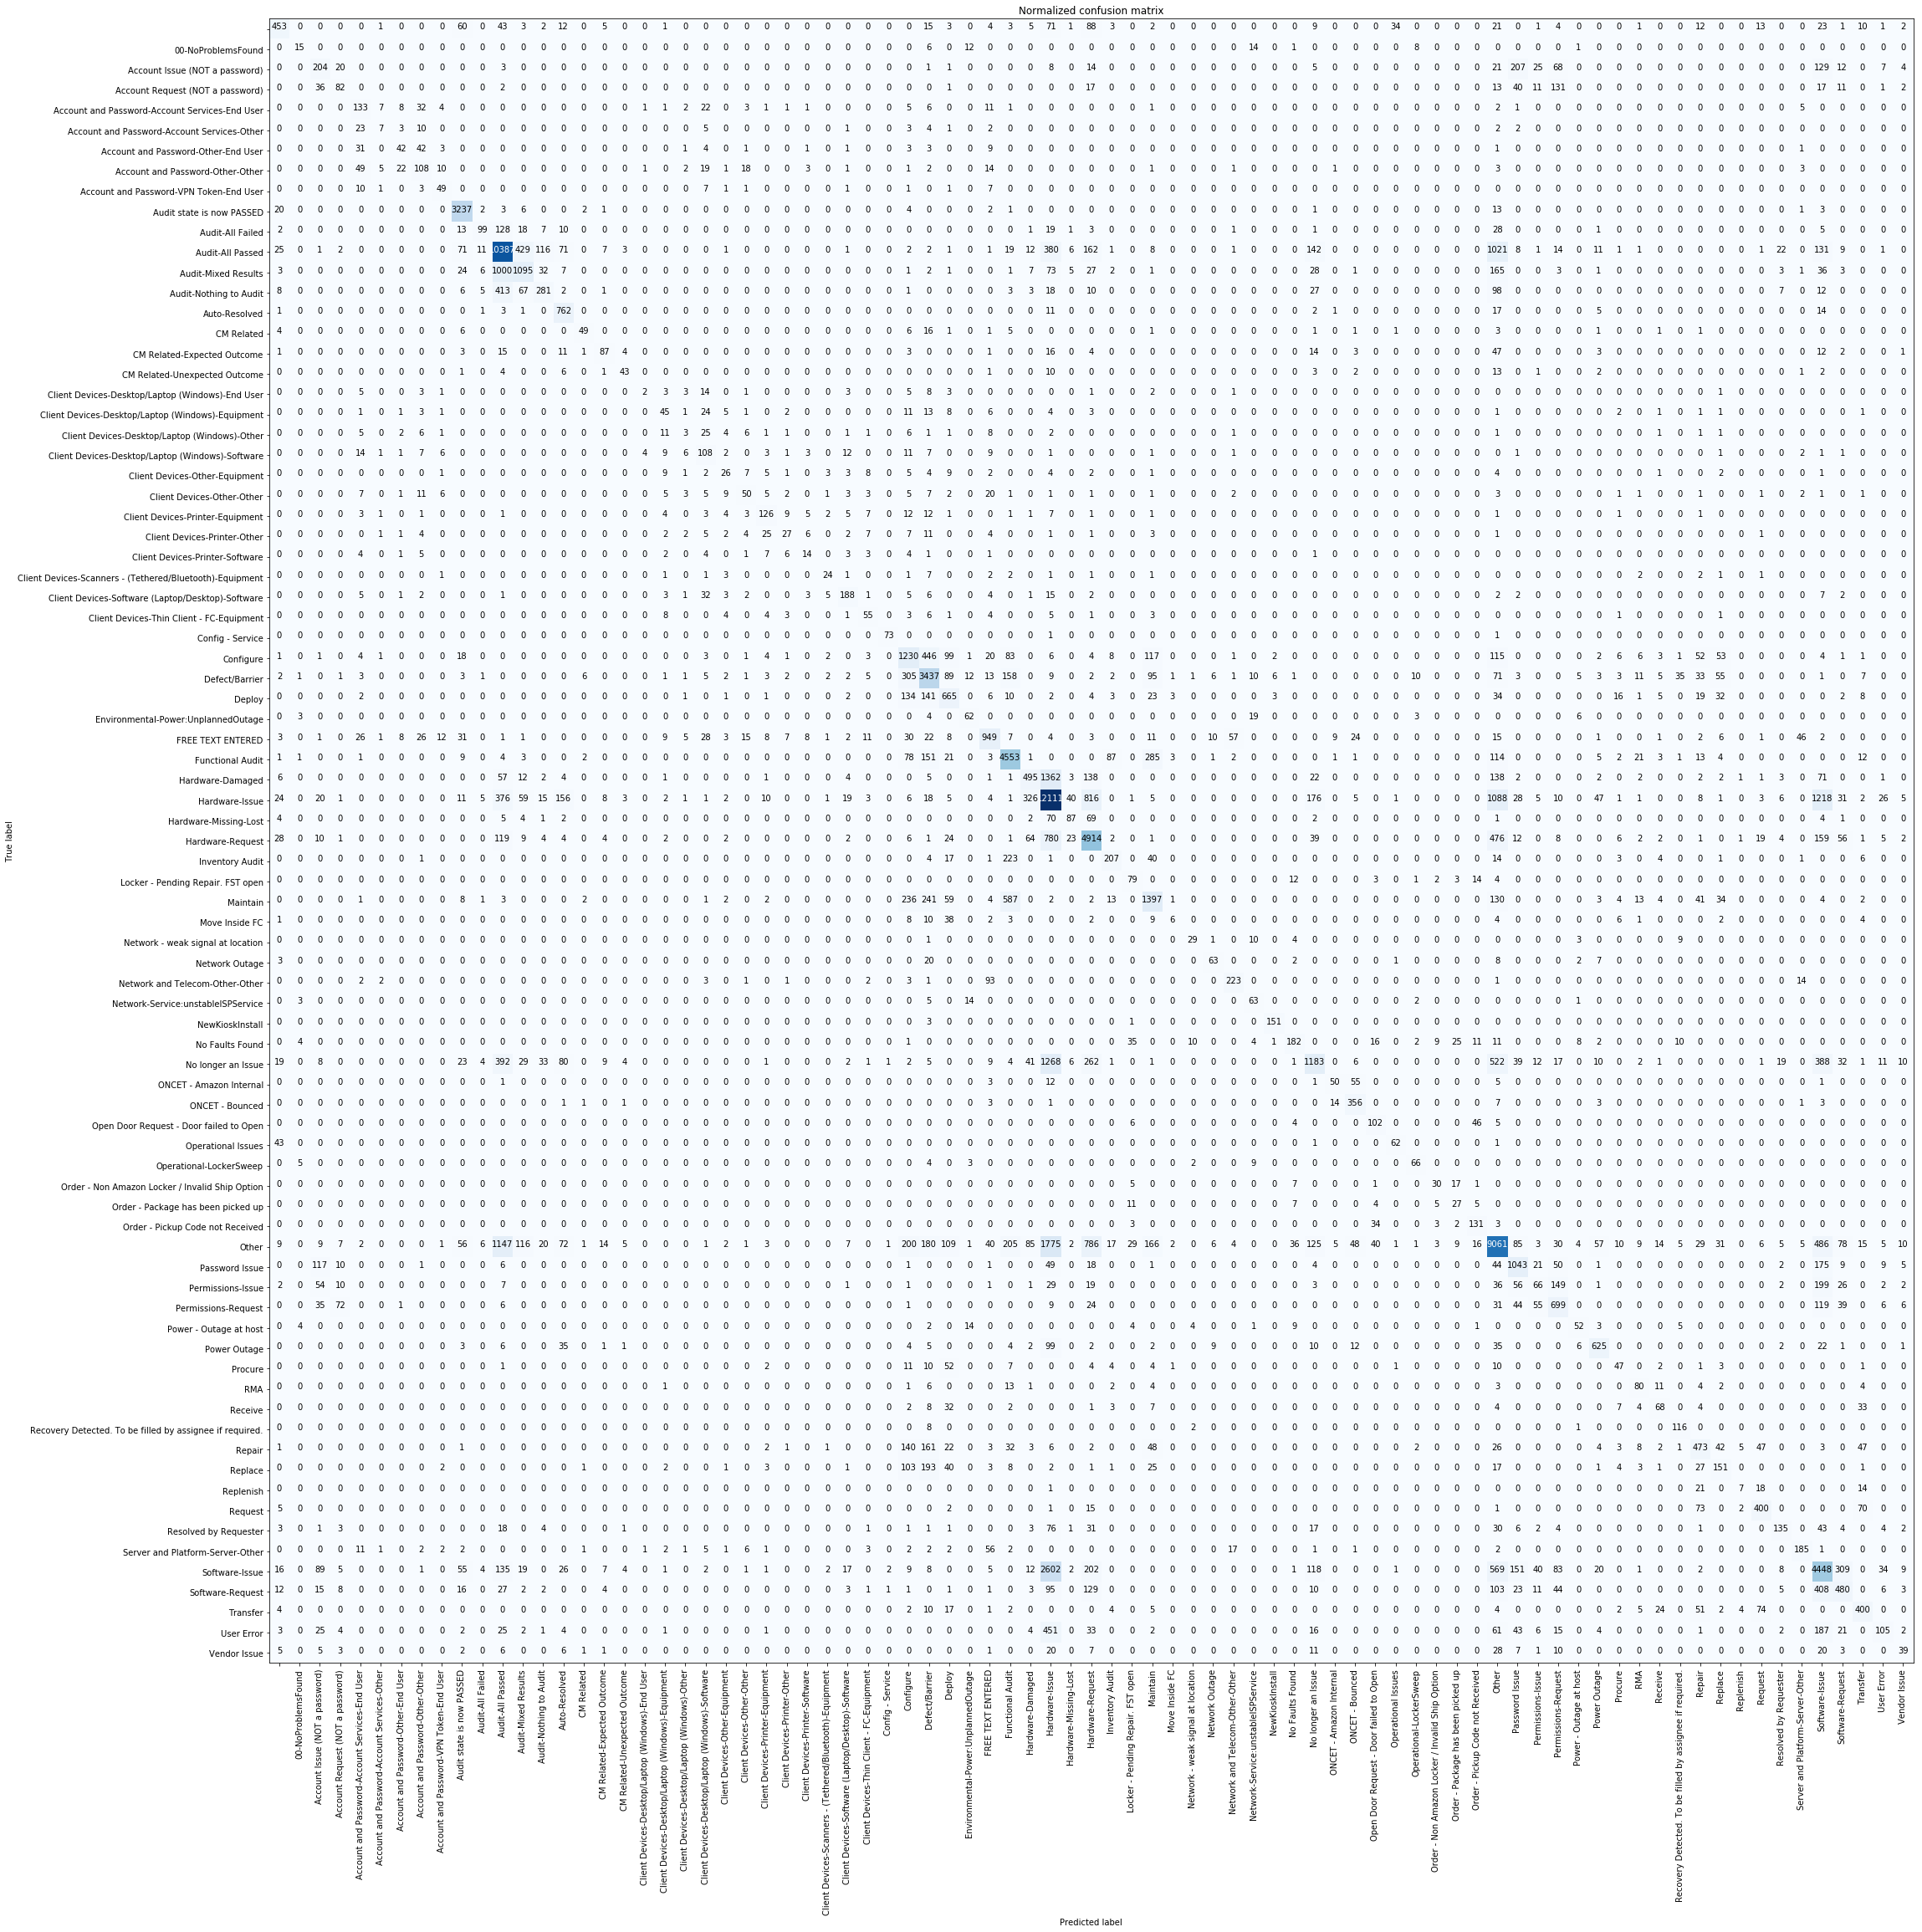

In [88]:
fig = plt.figure()
fig.set_size_inches(32, 32, forward=True)
plot_confusion_matrix(cnf_matrix, classes=data_test.classes, normalize=False, title='Normalized confusion matrix')